In [373]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# K-Means Algorithm
K-Means is a unsupervised learning technique that clusters given dataset to K clusters.  
This is achieved through the following steps:  
1. Initialize the K centroids  
Now iterate through following two steps:
2. Assign points to cluster centroids by calculating the squared L2 norm (Euclidean distance) and assigning sample to smallest distance to centroid
3. Move cluster centroids by finding the mean of the data points assigned to each cluster  
These steps are repeated until convergance is reached. Convergance condition will be explained later.

## Step 1: Initializing Centroids
The basic method is to choose random values for each K and go from there. However, K-Means is susceptible to converging onto local minima.  
### Random Initializtion
Instead of choosing random values, choose random data points as starting centroids. This is better than choosing random values as the centroids start within the data points instead of outside them, helping with converging speed.  
The problem it is still susceptible to converging onto local minima due to bad initial starts. Due to the speed of the algorithm, it is valid to just repeat it with different initializtion each time and take the best set of cluster out of them. The number of iterations ranges from 50 to 1000. Any less and you can't ensure the best center. Any more and you will increase the computational load for not much benefit.  
  
  
Initializing to good positions will ensure that K means converges to a good minimum and will converge faster. One such method is K-Means++:
### K-means++ Initialization

K-means++ is an algorithm for choosing the initial values (or "seeds") for the k-means clustering algorithm. Standard k-means is sensitive to the initial placement of cluster centers, and poor initialization can lead to suboptimal clustering results (e.g., converging to a local minimum with higher within-cluster variance). K-means++ addresses this issue by intelligently selecting initial centers that are well-spaced.

**Steps of K-means++ Initialization:**

1.  **Choose the first center randomly:** Select one data point uniformly at random from the dataset to be the first cluster center.

2.  **Calculate distances:** For each data point *x*, calculate the shortest distance *D(x)* between *x* and the nearest cluster center already chosen.

3.  **Choose the next center with weighted probability:** Choose a new cluster center from the remaining data points using a weighted probability distribution, where the probability of choosing a point *x* is proportional to *D(x)²*. In other words, points that are farther away from existing centers are more likely to be chosen as the next center.

4.  **Repeat steps 2 and 3:** Repeat steps 2 and 3 until *k* cluster centers have been chosen, where *k* is the desired number of clusters.

**Intuition behind K-means++:**

The key idea behind K-means++ is to spread out the initial cluster centers as much as possible. By choosing points that are far from existing centers, the algorithm tries to avoid starting with multiple centers clustered together in the same region of the data space. This helps prevent the algorithm from converging to poor local optima.

**Advantages of K-means++:**

*   **Improved clustering quality:** K-means++ generally leads to better clustering results compared to random initialization, as it is less likely to get stuck in poor local optima.
*   **Faster convergence:** Because the initial centers are well-spaced, k-means often converges faster when using K-means++ initialization.

**Comparison to random initialization:**

In standard k-means with random initialization, the initial centers are chosen completely randomly. This can lead to situations where multiple centers are close together, effectively wasting computational effort and potentially leading to poor clustering. K-means++ mitigates this risk by ensuring a more diverse set of initial centers.

In [374]:
# Step 1: Initialize cluster centroids
def choose_center(k, init, data, random_state=None):
    n_samples, n_features = data.shape
    centers = np.zeros((k, n_features))
    # Set random state if you want reproducable results
    if random_state is not None:
        np.random.seed(random_state) #seed numpy
        random.seed(random_state) #seed python random
        
    # Randomly choose data points as starting points for clusters with no replacement
    if init == 'random':
        centers = data[np.random.choice(data.shape[0], k, replace=False), :]
            
    # A slower algorithm that tries to make the starting clusters far away from each other to help K means converge faster
    if init == 'k-means++':
        # 1. Choose the first center randomly from the data points.
        centers[0] = data[np.random.randint(n_samples)]
    
        for i in range(1, k):
            # 2. For each data point x, compute D(x), the distance between x and the nearest center that has already been chosen.
            distances = np.zeros(n_samples)
            for j in range(n_samples):
                min_dist = float('inf')
                for l in range(i):  # Compare to already chosen centers
                    dist = np.linalg.norm(data[j] - centers[l])
                    min_dist = min(min_dist, dist)
                distances[j] = min_dist
    
            # 3. Choose one new data point as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)^2.
            probabilities = distances**2 / np.sum(distances**2)
            cumulative_probabilities = np.cumsum(probabilities)
            random_value = random.random()
            for j in range(n_samples):
                if random_value < cumulative_probabilities[j]:
                    centers[i] = data[j]
                    break

    return centers

## Step 2: Assign data points to clusters
This is simply done by calculating the distance between each data point with each K centroid. The datapoint is assigned to the centroid it is closest to. The distance calculated is squared because both squared and non squared have same minimum with the added benefit that we don't need to use a square root (which is computationaly exhausting)

In [375]:
# Step 2: Assign data points to nearest cluster center
def assign_clusters(data, clusters):
    for sample in data:
        distance_to_clusters = []
        # length clusters is passed instead of K because it could change during Step 3
        for i in range(len(clusters)):
            # Calculate the squared Euclidean distance (L2 Norm)
            distance = np.sum((sample - clusters[i]['center']) ** 2)
            distance_to_clusters.append(distance)
        # Find index of cluster that resulted in smallest distance and assign the data point to it
        assigned_cluster = np.argmin(distance_to_clusters)
        clusters[assigned_cluster]['samples'].append(sample)
    return clusters

## Step 3:  Update centroids of each cluster
After assiging the data points to their clusters, update the position of the centroid to be at the mean of the data points it is assigned to.  
It is possible that in the previous step that a centroid was not assigned any data points and therefore we cannot update its position any more. The solution is to either reassign it by finding a new random position or removing it entirely, reducing K by 1. This is the method used since it probably means that there was too many clusters in the first place.

In [376]:
# Step 3: Update cluster centers positions
def update_clusters(clusters):
    # length clusters is passed instead of K because it could change during Step 3
    for i in range(len(clusters)):
        samples = np.array(clusters[i]['samples'])
        # Need to check if number of samples assigned to a cluster is greater than zero before calculating the mean
        if samples.shape[0] > 0:
            # axis=0 means that means of each feature are calculated separately
            new_center = samples.mean(axis=0)
            clusters[i]['center'] = new_center
            # Reset points of cluster for the next iteration
            clusters[i]['samples'] = []
        else:
            print(f'cluster {i+1} was deleted!')
            del clusters[i]
    return clusters

## Calculating Within-Cluster Sum of Squares (WCSS) or Inertia

The Within-Cluster Sum of Squares (WCSS), also known as inertia, is a metric used to evaluate the quality of a clustering. It measures the sum of the squared distances between each data point and the centroid (mean) of its assigned cluster. A lower WCSS indicates that the data points are closer to their respective cluster centers, suggesting a tighter and more cohesive clustering.

In [377]:
# Calculate the within cluster sum of squares (WCSS) or inertia
def calculate_inertia(clusters):
    squared_distance_per_cluster = {}
    squared_distances = 0
    for i in range(len(clusters)):
        center = clusters[i]['center']
        samples = np.array(clusters[i]['samples'])
        cluster_distance = np.sum((samples - center) ** 2)
        squared_distance_per_cluster[i] = cluster_distance
        squared_distances += cluster_distance
    return squared_distances, squared_distance_per_cluster

## Putting it all together
After applying the above steps, we need to check for convergence to break away early from iterations. The convergance condition is that the assignment on new clusters is not different from previous.   
Another check which is implemented here is to check the change of position of the centroids each iteration. If it is less than a specified tolerance end loops early.   
Another check would be to check on the change in inertia in the same way as that of centroids, but this is not required for most general applications.  
The final convergence test is to run until a max number of iterations and then output the result.  
The tolerance is specified according to the precision required of K means. A smaller value will require more iterations but will result in a more precise centroid.

In [378]:
# Join all previous functions together
# init can be 'k-means++' or 'random' for initialization using random data points
# an init of 'random' requires a number of repititions to produce the best set of clusters
# K means++ doesn't require repititions since it should produce initial centers that are away from each other
from copy import deepcopy
def kmeans(data, k, init='k-means++', reps=50, max_iter=100, tolerance=1e-10, random_state=None):
    n_samples, n_features = data.shape
    if init == 'k-means++':
        reps = 3
    clusters_list = []
    # Repeat K means with multiple inital starts to get a list of different clusters
    for _ in range(reps):
        # Step 1: Initialize clusters
        clusters = {}
        centers = choose_center(k, init, data, random_state)
        for i in range(k):
            cluster = {
                'center' : centers[i],
                'samples' : []
            }
            clusters[i] = cluster
        # Now enter loop to find best center positions
        old_cost = float('inf')
        old_clusters = deepcopy(clusters) # Create deepcopy so changes in original don't reflect in new variable
        for c in range(max_iter):
            # Step 2: Assign data points to nearest cluster center
            clusters = assign_clusters(data, clusters)
            
            # Step 3: Update cluster centers positions
            clusters = update_clusters(clusters)
            
            # Check for convergence: 
            old_centers = np.array([old_clusters[cluster]['center'] for cluster in old_clusters])
            new_centers = np.array([clusters[cluster]['center'] for cluster in clusters])
            #print([old_clusters[cluster]['center'] for cluster in old_clusters])
            #print([clusters[cluster]['center'] for cluster in clusters])
            if np.all(np.abs(old_centers - new_centers) < tolerance):
                clusters_list.append(clusters)
                #print(c)
                break
            if c == max_iter - 1:
                clusters_list.append(clusters)
            old_clusters = deepcopy(clusters) # Create deepcopy so changes in original don't reflect in new variable
            
    # Find the best cluster by finding least cost
    best_cost = float('inf')
    best_clusters = {}
    for clusters in clusters_list:
        # After final iteration, points are not assigned to updated cluster positions yet and therefore must assign before calculating cost
        clusters = assign_clusters(data, clusters)
        cost, _ = calculate_inertia(clusters)
        #print(cost)
        if cost < best_cost:
            best_cost = cost
            best_clusters = clusters
    return best_cost, best_clusters

## Comparison
Now compare our algorithm with that of sklearn by testing on a 4 blobs scatterplot. Compare the elbow method to find that both are almost identical

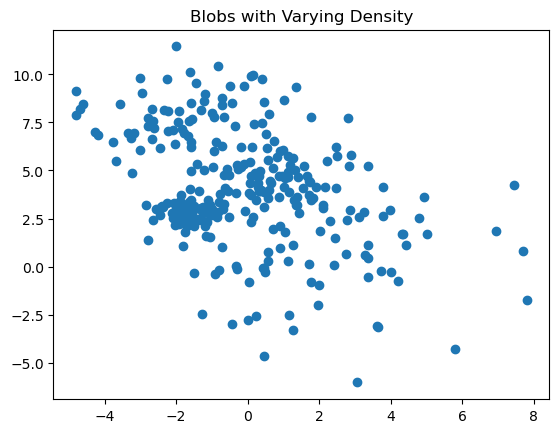

In [379]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, cluster_std=[1.0, 2.5, 0.5, 1.5], random_state=0) #cluster_std controls the standard deviation of each cluster
plt.scatter(X[:, 0], X[:, 1])
plt.title("Blobs with Varying Density")
plt.show()

Final cost: 1029.8937984744637


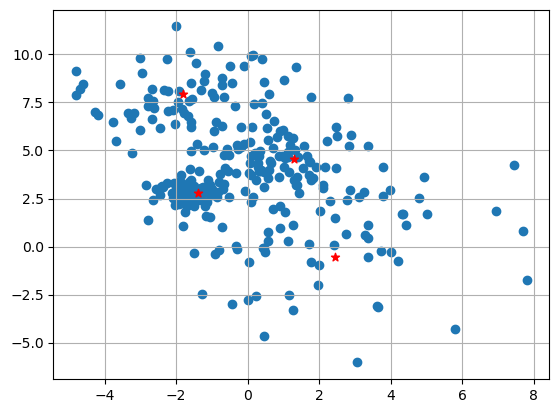

In [380]:
k = 4
cost, clusters = kmeans(X, k, init='k-means++', random_state = None)
print(f'Final cost: {cost}')
plt.scatter(X[:,0],X[:,1])
plt.grid(True)
for i in clusters:
    center = clusters[i]['center']
    plt.scatter(center[0],center[1],marker = '*',c = 'red')
plt.show()

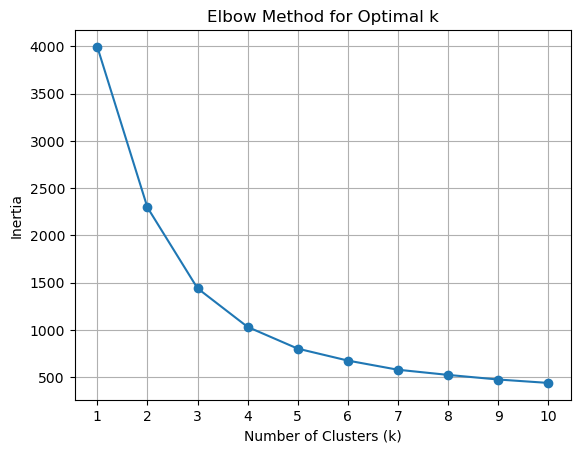

C:\Users\pc\anaconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\pc\anaconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\pc\anaconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\pc\anaconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans 

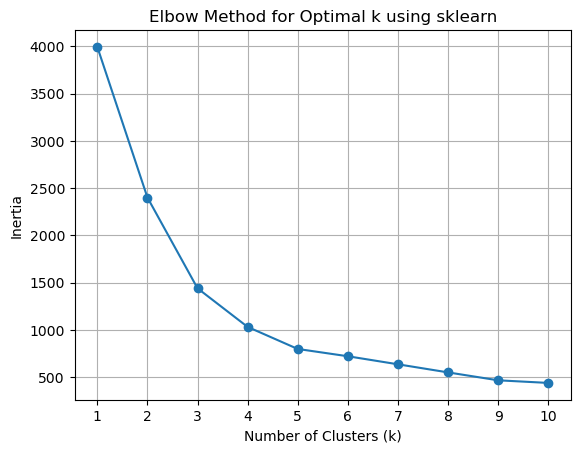

In [381]:
# Range of k values to test
k_values = range(1, 11)  # Test k from 1 to 10

inertias = []
for k in k_values:
    cost, clusters = kmeans(X, k, init='k-means++', random_state = None)
    inertias.append(cost)

# Plot the elbow method graph
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values) #set ticks to be only the k values
plt.grid(True)
plt.show()

#Example using sklearn
from sklearn.cluster import KMeans
inertias_sk = []
for k in k_values:
    kmeans_sk = KMeans(n_clusters=k, random_state=42, n_init = 'auto')
    kmeans_sk.fit(X)
    inertias_sk.append(kmeans_sk.inertia_)
plt.plot(k_values, inertias_sk, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k using sklearn")
plt.xticks(k_values) #set ticks to be only the k values
plt.grid(True)
plt.show()
